In [1]:
import os, sys
sys.path.append(os.path.abspath(os.path.join('../../..'))) # access sibling directories
sys.path.append("C:\\Users\\lasse\\Documents\\GitHub\\BayesFlow")

from src.python.settings import summary_meta_validation, evidence_meta_validation
from src.python.networks import HierarchicalInvariantNetwork, EvidentialNetwork
from src.python.models import HierarchicalSdtMptSimulator, MainSimulator
from src.python.losses import multi_task_loss
from src.python.helpers import n_clust_obs_f_f, get_multiple_predictions, get_preds_and_bfs
from src.python.visualization import perf_tester, plot_calibration_curve, plot_calibration_curve_repetition_uncertainty

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.experimental import CosineDecay
from tensorflow.keras.optimizers import Adam
from functools import partial
from time import perf_counter
from datetime import datetime, timezone, timedelta
import matplotlib.pyplot as plt

from bayesflow.trainers import ModelComparisonTrainer
from bayesflow.amortizers import MultiModelAmortizer
from bayesflow.losses import log_loss

In [2]:
# Hack to correctly set facecolor to white
# matplotlib 3.5 only sets facecolor if a plot was already created 
_ = plt.figure()
plt.rcParams['figure.facecolor'] = 'w'

<Figure size 432x288 with 0 Axes>

# Set up networks

In [3]:
summary_net = HierarchicalInvariantNetwork(summary_meta_validation)
evidence_net = EvidentialNetwork(evidence_meta_validation)

amortizer = MultiModelAmortizer(evidence_net, summary_net)

simulator = MainSimulator(HierarchicalSdtMptSimulator())

In [6]:
# Cosine Decay with Restarts
epochs=15 
iterations_per_epoch=1000

initial_lr = 0.0005
decay_steps = epochs*iterations_per_epoch
alpha = 0

lr_schedule = CosineDecay(
    initial_lr, decay_steps, alpha=alpha
    )

# Checkpoint path for loading pretrained network and saving the final network
checkpoint_path = "c:\\Users\\lasse\\documents\\hierarchical model comparison project\\checkpoints\\02_bridge_sampling_comparison\\non_nested_models"

trainer = ModelComparisonTrainer(
    network=amortizer, 
    generative_model=simulator, 
    loss=partial(multi_task_loss, kl_weight=0.25),
    optimizer=partial(Adam, lr_schedule),
    #checkpoint_path=checkpoint_path,
    skip_checks=True,
    )

# Sample size
n_clusters = 25
n_obs = 50

# Train

In [7]:
training_time_start = perf_counter()
losses = trainer.train_online(
    epochs=epochs, iterations_per_epoch=iterations_per_epoch, batch_size=32, 
    n_obs=partial(n_clust_obs_f_f, n_clusters, n_obs), n_vars=2)
training_time_stop = perf_counter()

Training epoch 1:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 2:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 3:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 4:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 5:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 6:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 7:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 8:   0%|          | 0/1000 [00:00<?, ?it/s]

KeyboardInterrupt: 

# Validate

In [ ]:
# Simulate data
n_data_sets = 5000

m_val, _, x_val = simulator(batch_size=n_data_sets, n_obs=n_clust_obs_f_f(n_clusters, n_obs), n_vars=2)
val_data = {'X' : x_val, 'm' : m_val}

ECE = 0.004


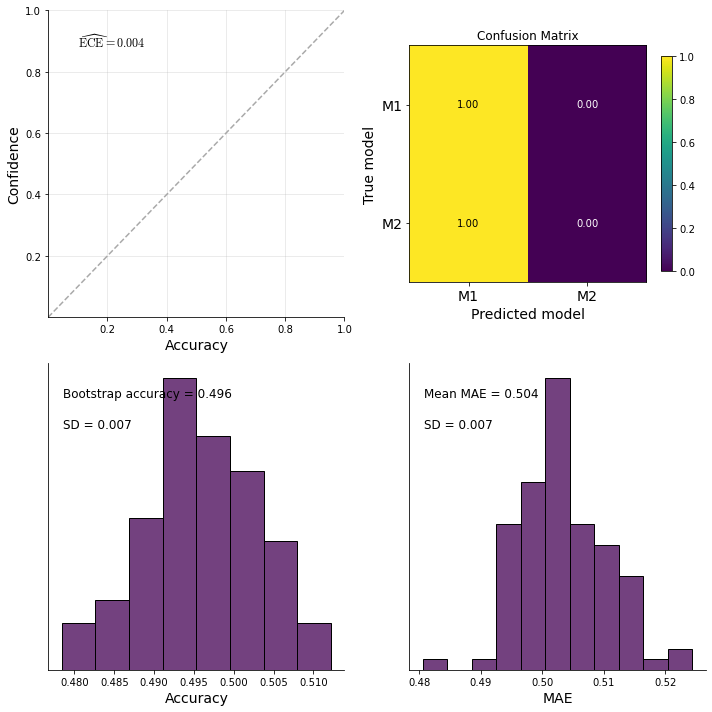

In [ ]:
# Performance of the evidential output
perf_tester(evidence_net, summary_net, val_data, output_softmax=False, n_cal_bins=15)

ECE = 0.002


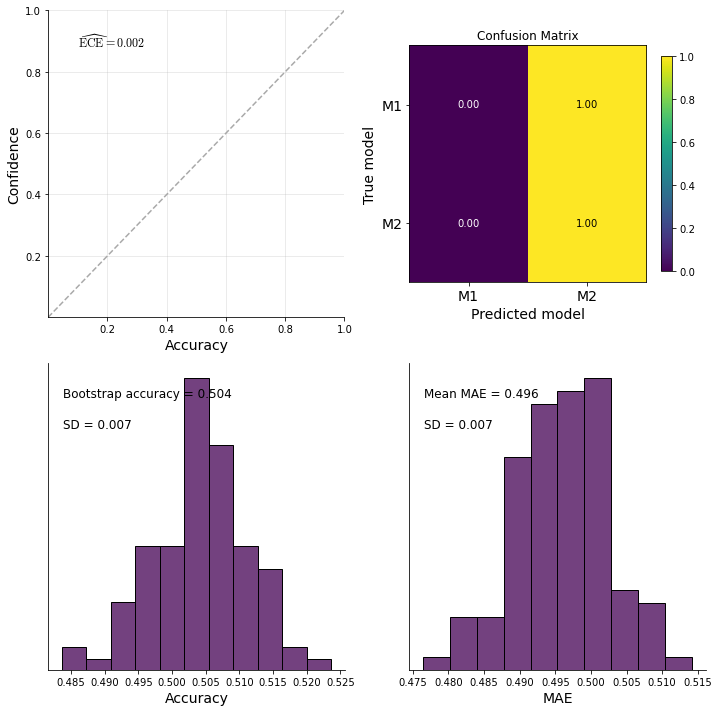

In [ ]:
# Performance of the softmax output
perf_tester(evidence_net, summary_net, val_data, output_softmax=True, n_cal_bins=15)

KeyboardInterrupt: 

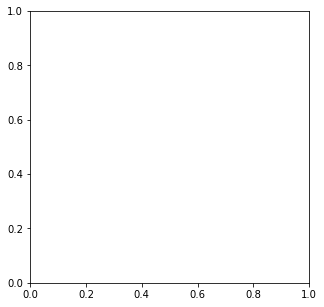

In [10]:
# Plot calibration with repetition uncertainty
fig, ax = plt.subplots(1, 1, figsize=(5,5))

m_true_r, m_soft_r = get_multiple_predictions(evidence_net, summary_net, partial(simulator, batch_size=n_data_sets, n_obs=n_clust_obs_f_f(n_clusters, n_obs), n_vars=2), 
                                          n_models=2, procedure='repeated', n_repetitions=20)

plot_calibration_curve_repetition_uncertainty(m_true_r, m_soft_r, narrow_ci=[0.025, 0.975], wide_ci=[0.25, 0.75], n_bins=15, ax=ax, 
                                    xlabel=True, ylabel=True, title=None, show_ece=True, show_legend=True)

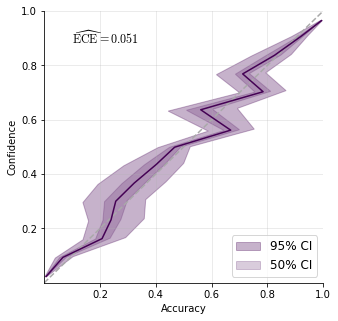

In [10]:
# Plot calibration with bootstrap uncertainty
fig, ax = plt.subplots(1, 1, figsize=(5,5))

m_true_b, m_soft_b = get_multiple_predictions(evidence_net, summary_net, partial(simulator, batch_size=n_data_sets, n_obs=n_clust_obs_f_f(n_clusters, n_obs), n_vars=2), 
                                          n_models=2, procedure='bootstrap', n_bootstrap=200)

plot_calibration_curve_repetition_uncertainty(m_true_b, m_soft_b, narrow_ci=[0.025, 0.975], wide_ci=[0.25, 0.75], n_bins=15, ax=ax, 
                                    xlabel=True, ylabel=True, title=None, show_ece=True, show_legend=True)

# Calculate Bayes factors for bridge sampling comparison

In [13]:
# Import training meta-information? (if network was loaded from checkpoint)

# TODO

In [6]:
# Import test data
val_folder = os.path.join(os.path.dirname(os.path.dirname(os.path.dirname(os.getcwd()))),'data', '02_bridge_sampling_comparison','non_nested_models')
data_filename = "test_data.npy"
test_data = np.load(os.path.join(val_folder, data_filename), allow_pickle=True).item()

In [7]:
# Get NN predictions
comparison_results = get_preds_and_bfs(evidence_net, summary_net, test_data, training_time_start, training_time_stop, losses)
comparison_results.head(5)

,dataset,true_model,m0_prob,m1_prob,selected_model,bayes_factor,training_time,inference_time,final_epoch_loss
0,1,0,0.964281,0.035719,0,0.037042,1182.864466,0.004911,0.557
1,2,0,0.965821,0.034179,0,0.035388,1182.864466,0.004911,0.557
2,3,0,0.991281,0.008719,0,0.008796,1182.864466,0.004911,0.557
3,4,1,0.412878,0.587122,1,1.422026,1182.864466,0.004911,0.557
4,5,0,0.965792,0.034208,0,0.035419,1182.864466,0.004911,0.557


In [13]:
# Export results
local_timezone = datetime.now(timezone(timedelta(0))).astimezone().tzinfo
filename = pd.Timestamp.today(tz=local_timezone).strftime('%Y_%m_%d_BF_NNa')
comparison_folder = os.path.join(os.path.dirname(os.path.dirname(os.path.dirname(os.getcwd()))),'data', '02_bridge_sampling_comparison','non_nested_models')

comparison_results.to_csv(os.path.join(comparison_folder, filename), index = False)